EXPERIMENT 6 - KNN


Name : Amishi Gupta

Roll No.: 23/CS/048

In [1]:
#prerequisites
!pip install numpy pandas matplotlib scikit-learn ucimlrepo

In [5]:
%%writefile data.py

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

def load_data(dataset_id=53):
    #fetch dataset
    dataset =fetch_ucirepo(id=dataset_id)
    X_df = dataset.data.features
    y_df = dataset.data.targets

    if dataset_id ==53: #iris dataset
        y =y_df.iloc[:,0].str.replace('Iris-', '')

    elif dataset_id== 109: #wine dataset
        y = y_df.iloc[:, 0]

    X_np = X_df.to_numpy()
    y_np = y.to_numpy()

    feature_names = X_df.columns.to_list()

    return X_np, y_np, feature_names

if __name__ == '__main__':
    print("Iris Data")
    X_iris, y_iris, features_iris = load_data(53)
    print(f"Iris X shape: {X_iris.shape}")
    print(f"Iris y shape: {y_iris.shape}")
    print(f"Iris features: {features_iris}")
    print(f"Iris unique labels: {np.unique(y_iris)}")
    print(f"First 5 Iris labels: {y_iris[:5]}\n")

    print("Wine Data")
    X_wine, y_wine, features_wine = load_data(109)
    print(f"Wine X shape: {X_wine.shape}")
    print(f"Wine y shape: {y_wine.shape}")
    print(f"Wine features: {features_wine}")
    print(f"Wine unique labels: {np.unique(y_wine)}")
    print(f"First 5 Wine labels: {y_wine[:5]}")

Overwriting data.py


In [6]:
%%writefile utils.py

import numpy as np

def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    split_index = int(num_samples * (1-test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train=X[train_indices]
    y_train = y[train_indices]
    X_test=X[test_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

if __name__ == '__main__':
    print("Testing train test split")
    X_data = np.arange(100).reshape((50, 2))
    y_data = np.arange(50)

    X_tr, X_te, y_tr, y_te = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

    print(f"Original X shape: {X_data.shape}")
    print(f"Train X shape: {X_tr.shape}")
    print(f"Test X shape: {X_te.shape}")

    print(f"\nOriginal y shape: {y_data.shape}")
    print(f"Train y shape: {y_tr.shape}")
    print(f"Test y shape: {y_te.shape}")

    print(f"\nTest labels (to check shuffle): {y_te}")

Overwriting utils.py


In [7]:
%%writefile knn_classifier.py

import numpy as np
from collections import Counter

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

class KNNClassifier:

    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]

        k_nearest_indices =np.argsort(distances)[:self.k]

        k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]

        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

if __name__ == '__main__':
    #test the classifier
    print("KNNClassifier")
    X_tr_test = np.array([[1, 1],[1, 2], [2, 1],[6, 6],[6, 7],[7, 6]])
    y_tr_test = np.array(['A','A','A','B','B','B'])

    knn = KNNClassifier(k=3)
    knn.fit(X_tr_test, y_tr_test)

    X_te_test = np.array([[2, 2], [5, 5]])
    predictions = knn.predict(X_te_test)

    print(f"Test data: {X_te_test}")
    print(f"Predictions: {predictions}")
    print(f"Test passed: {list(predictions) == ['A', 'B']}")

Overwriting knn_classifier.py


In [8]:
%%writefile eda.py

import matplotlib.pyplot as plt
import numpy as np
from data import load_data
import itertools

def run_eda():
    X, y, feature_names = load_data(dataset_id=53)
    class_labels = np.unique(y)

    colors = ['red', 'green', 'blue']
    color_map = {label: color for label, color in zip(class_labels, colors)}

    num_features = X.shape[1]
    feature_pairs = list(itertools.combinations(range(num_features), 2))

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    axes = axes.flatten()

    for i, (feat_idx_1, feat_idx_2) in enumerate(feature_pairs):
        ax = axes[i]

        for label in class_labels:
            class_data = X[y == label]
            ax.scatter(
                class_data[:, feat_idx_1], #x-axis data
                class_data[:, feat_idx_2], #y-axis data
                c=color_map[label],
                label=label,
                alpha=0.7
            )

        ax.set_xlabel(feature_names[feat_idx_1])
        ax.set_ylabel(feature_names[feat_idx_2])
        ax.set_title(f'{feature_names[feat_idx_1]} vs. {feature_names[feat_idx_2]}')
        ax.legend()
        ax.grid(True)

    for j in range(len(feature_pairs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    plt.savefig('iris_eda_plots.png')
    print("EDA plots saved to 'iris_eda_plots.png'")

if __name__ == '__main__':
    run_eda()

Writing eda.py


In [9]:
%%writefile main.py

import numpy as np
import matplotlib.pyplot as plt
from data import load_data
from utils import train_test_split
from knn_classifier import KNNClassifier

def calculate_accuracy(y_pred, y_true):
    correct_predictions = np.sum(y_pred == y_true)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

def run_iris_pipeline():
    print("starting Iris Dataset Pipeline")

    X, y, _ = load_data(dataset_id=53)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    # 2. Evaluate for k=3
    print("\nvaluation for k=3")
    knn_k3 = KNNClassifier(k=3)
    knn_k3.fit(X_train, y_train)
    y_pred_k3 = knn_k3.predict(X_test)

    accuracy_k3 = calculate_accuracy(y_pred_k3, y_test)
    print(f"Accuracy for k=3: {accuracy_k3 * 100:.2f}%")

    # 3. Hyperparameter Tuning and Analysis
    print("Hyperparameter Tuning")
    k_values = [1, 3, 5, 7, 9, 11, 15]
    accuracies = []

    for k in k_values:
        knn = KNNClassifier(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = calculate_accuracy(y_pred, y_test)
        accuracies.append(acc)
        print(f"k = {k:2}, Accuracy ={acc * 100:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, marker='o', linestyle='-')
    plt.title('Accuracy vs. k-value for Iris Dataset')
    plt.xlabel('k-value')
    plt.ylabel('Accuracy')
    plt.xticks(k_values)
    plt.grid(True)
    plt.savefig('iris_accuracy_vs_k.png')

    best_k_index = np.argmax(accuracies)
    best_k = k_values[best_k_index]
    best_acc = accuracies[best_k_index]
    print(f"Best k value found:{best_k} (with accuracy: {best_acc * 100:.2f}%)")

    return best_k

def run_wine_pipeline(best_k):

    print("\nGeneralization to Wine Dataset")
    print(f"Using best k from Iris experiment: k={best_k}")

    X, y, _ = load_data(dataset_id=109)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Wine Training set size: {X_train.shape[0]} samples")
    print(f"Wine Test set size: {X_test.shape[0]} samples")

    knn = KNNClassifier(k=best_k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = calculate_accuracy(y_pred, y_test)
    print(f"\nFinal Accuracy on Wine Dataset (k={best_k}): {accuracy * 100:.2f}%")

if __name__ == '__main__':
    best_k_from_iris = run_iris_pipeline()

    run_wine_pipeline(best_k_from_iris)

Writing main.py


EDA plots saved to 'iris_eda_plots.png'

EDA Plot Result


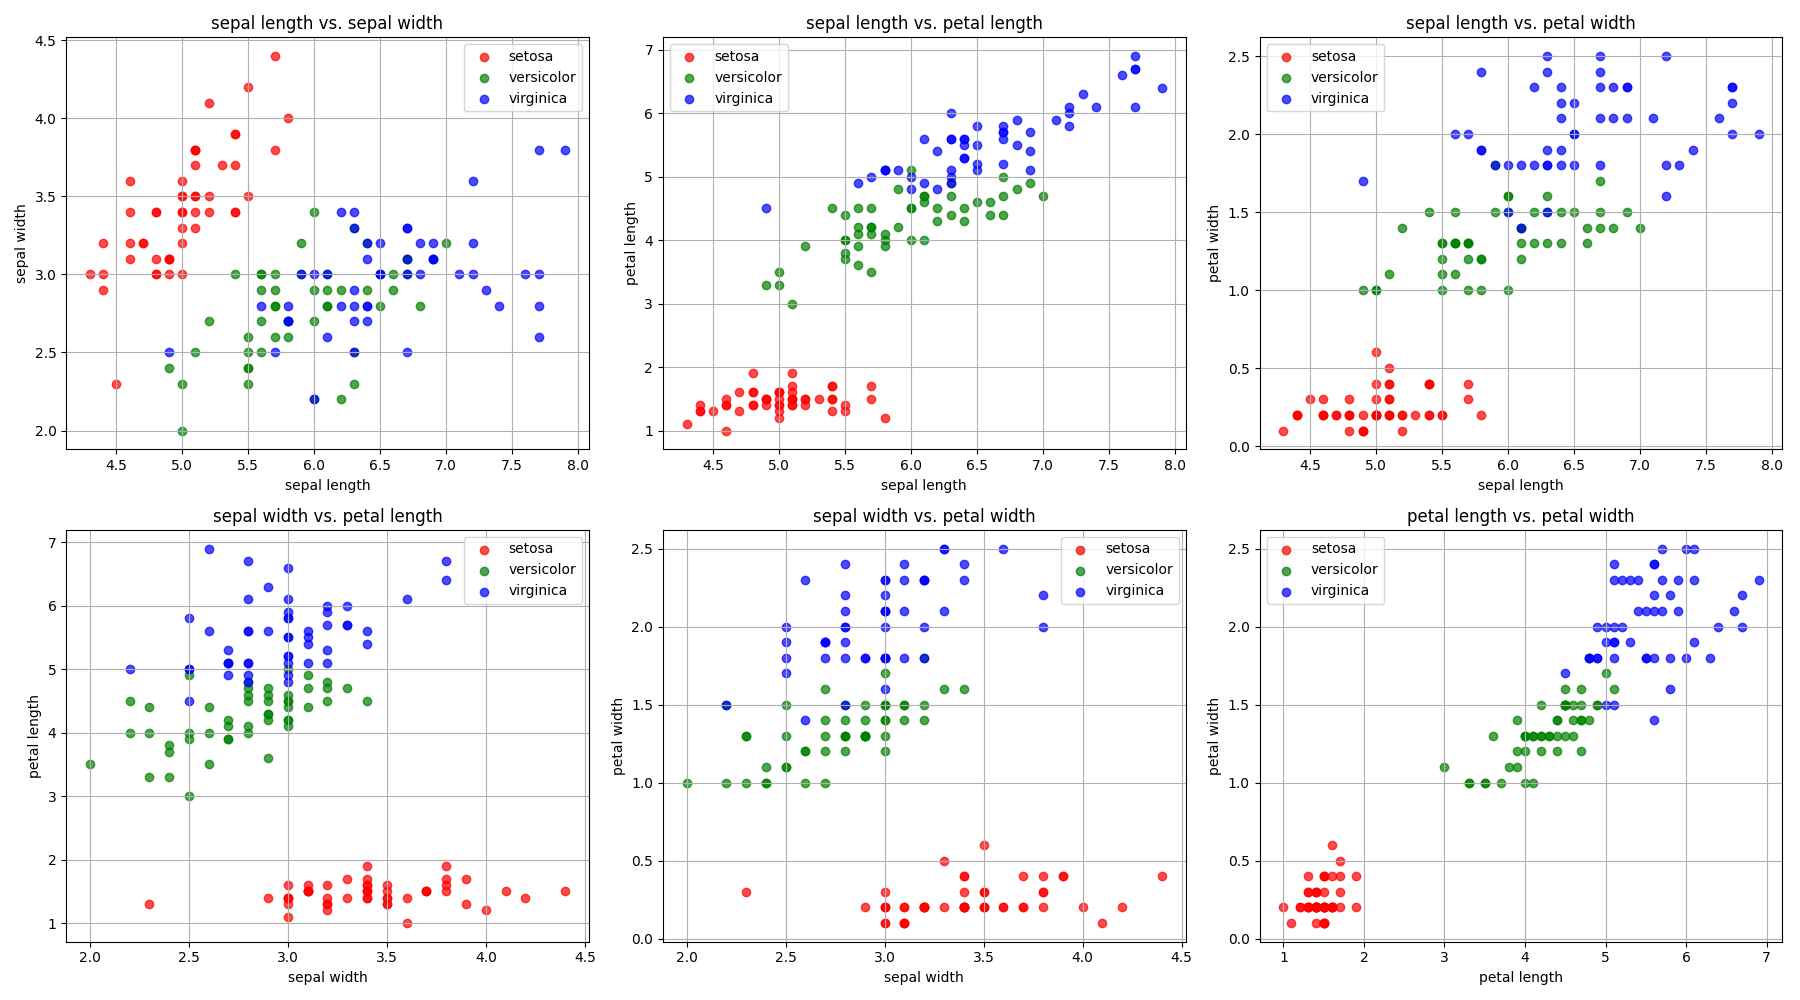

In [10]:
!python eda.py

#display the plot generated by the script
from IPython.display import Image, display
print("\nEDA Plot Result")
display(Image(filename='iris_eda_plots.png'))

starting Iris Dataset Pipeline
Training set size: 120 samples
Test set size: 30 samples

valuation for k=3
Accuracy for k=3: 96.67%
Hyperparameter Tuning
k =  1, Accuracy =96.67%
k =  3, Accuracy =96.67%
k =  5, Accuracy =96.67%
k =  7, Accuracy =96.67%
k =  9, Accuracy =96.67%
k = 11, Accuracy =96.67%
k = 15, Accuracy =96.67%
Best k value found:1 (with accuracy: 96.67%)

Generalization to Wine Dataset
Using best k from Iris experiment: k=1
Wine Training set size: 142 samples
Wine Test set size: 36 samples

Final Accuracy on Wine Dataset (k=1): 72.22%

Accuracy vs. k Plot Result


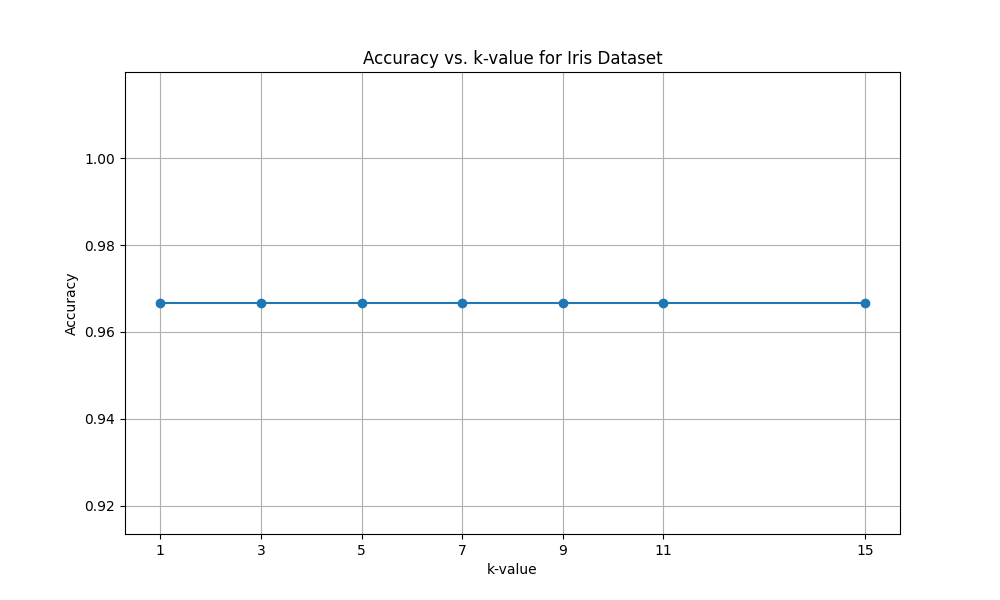

In [11]:
!python main.py

#display the accuracy plot generated by the script
from IPython.display import Image, display
print("\nAccuracy vs. k Plot Result")
display(Image(filename='iris_accuracy_vs_k.png'))